# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data Processing of Dataset 1

In [2]:
cyber1 = pd.read_csv('../datasets/cb_multi_labeled_unbalanced.csv', encoding='ISO-8859-1')
cyber1

,text,label
0,@user nice new signage. Are you not concerned ...,hate
1,A woman who you fucked multiple times saying y...,hate
2,@user @user real talk do you have eyes or were...,hate
3,your girlfriend lookin at me like a groupie in...,hate
4,Hysterical woman like @user,hate
...,...,...
51981,can the sacred be abused? embeddedurl iartg me...,spiritual
51982,"dbashideas you are right about the yevamos, th...",spiritual
51983,monetizing basic rights including spirituality...,spiritual
51984,where do you channel your reiki energy from? e...,spiritual


In [3]:
cyber1['label'].value_counts()

label
offensive    14100
hate         12914
religion     10478
spiritual     9442
emotion       5052
Name: count, dtype: int64

In [4]:
cyber1.drop_duplicates(subset = ['text'], inplace = True)
cyber1.duplicated().sum()

0

# Data Processing of Dataset 2

In [5]:
cyber2 = pd.read_csv('../datasets/cyberbullying_tweets.csv')
cyber2.rename(columns = {'tweet_text' : 'text', 'cyberbullying_type' : 'label'}, inplace = True)
cyber2

,text,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [6]:
cyber2['label'].value_counts()

label
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [7]:
cyber2.drop_duplicates(subset = ['text'], inplace = True)
cyber2.duplicated().sum()

0

In [8]:
# Filter out rows where label is 'none'
#cyber1 = cyber1[cyber1['cyberbullying_type'] != 'other_cyberbullying']

# Splitting Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming cyber1 is your DataFrame with columns 'text' and 'label'
texts = cyber1['text']
labels = cyber1['label']

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
label_mapping = {original_label: int_label for original_label, int_label in zip(cyber1['label'], encoded_labels)}
print(label_mapping)
# Split the data into training and testing sets (80-20 split)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets (80-20 split)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

{'hate': 1, 'offensive': 2, 'emotion': 0, 'religion': 3, 'spiritual': 4}


# Importing and Fine Tuning the Model

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader
import torch
import numpy as np
import time  # For measuring inference time

# Define a function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Compute error rate (1 - accuracy)
    error_rate = 1 - accuracy

    # Compute classification report
    class_report = classification_report(labels, predictions, output_dict=True)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, predictions).tolist()  # Convert to a list to make it JSON serializable

    # Combine all the metrics into a dictionary
    metrics = {
        'accuracy': accuracy, 
        'error_rate': error_rate, 
        'classification_report': class_report, 
        'confusion_matrix': conf_matrix
    }

    return metrics

# Load the XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Prepare your data
def tokenize_data(data, labels):
    encodings = tokenizer(data, truncation=True, padding=True)
    return {"input_ids": encodings['input_ids'], "attention_mask": encodings['attention_mask'], "labels": labels}

train_texts = list(train_texts)
valid_texts = list(valid_texts)
train_data = tokenize_data(train_texts, train_labels)
valid_data = tokenize_data(valid_texts, valid_labels)

# Create a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # Ensure labels are of type LongTensor (needed by CrossEntropyLoss)
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.encodings['labels'][idx], dtype=torch.long)  # Convert labels to long type
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create train and validation datasets
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)

# Define the XLNet model for sequence classification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(set(train_labels)))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./output',  # Directory for storing outputs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',   # Directory for storing logs
    report_to=[],           # Disable all logging
    evaluation_strategy="epoch",  # Evaluate once per epoch
    logging_steps=500,      # Log every 500 steps
)

# Custom Trainer to measure inference time during evaluation
class CustomTrainer(Trainer):
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        # Record start time for evaluation
        start_time = time.time()
        
        # Call the original Trainer evaluation function
        results = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)

        # Record end time for evaluation
        end_time = time.time()
        
        # Calculate inference time (in seconds)
        inference_time = end_time - start_time
        results['inference_time'] = inference_time
        
        return results

# Create CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,  # or test_dataset
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Testing the Model

In [12]:
import time
import psutil
from codecarbon import EmissionsTracker
import torch

# Assuming test_texts and test_labels are defined somewhere

# Initialize the EmissionsTracker from CodeCarbon to track energy consumption
tracker = EmissionsTracker(project_name="model_inference")

# Tokenize the test dataset
test_texts = list(test_texts)  # Ensure test_texts is a list
test_data = tokenize_data(test_texts, test_labels)

# Create the test dataset using the CustomDataset class
test_dataset = CustomDataset(test_data)

# Start the energy tracker
tracker.start()

# Start measuring inference time
start_time = time.time()

# Measure initial CPU and RAM usage before evaluation
cpu_before = psutil.cpu_percent(interval=1)  # CPU usage in %
ram_before = psutil.virtual_memory().used / (1024 ** 2)  # RAM usage in MB

# Evaluate the model on the test dataset using the CustomTrainer
results = trainer.evaluate(test_dataset)

# End measuring inference time
end_time = time.time()
inference_time = end_time - start_time

# Measure CPU and RAM usage after evaluation
cpu_after = psutil.cpu_percent(interval=1)  # CPU usage in %
ram_after = psutil.virtual_memory().used / (1024 ** 2)  # RAM usage in MB

# Stop the energy tracker and calculate energy consumption
tracker.stop()

# Energy consumed during evaluation in kWh
energy_consumed = tracker.final_emissions  # Accessing property directly

# Print the evaluation results (including inference time and resource usage)
print("Evaluation Results:", results)
print(f"Inference Time: {inference_time:.2f} seconds")
print(f"CPU Usage: {cpu_after - cpu_before:.4f}%")
print(f"RAM Usage: {ram_after - ram_before:.2f} MB")
print(f"Energy Consumed: {energy_consumed:.6f} kWh")

[codecarbon INFO @ 02:58:53] [setup] RAM Tracking...
[codecarbon INFO @ 02:58:53] [setup] GPU Tracking...
[codecarbon INFO @ 02:58:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:58:53] [setup] CPU Tracking...
[codecarbon WARNING @ 02:58:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 02:58:54] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 02:58:54] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 02:58:54] >>> Tracker's metadata:
[codecarbon INFO @ 02:58:54]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 02:58:54]   Python version: 3.11.5
[codecarbon INFO @ 02:58:54]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 02:58:54]   Available RAM : 31.696 GB
[codecarbon INFO @ 02:58:54]   CPU count: 32
[codecarbon INFO @ 02:58:54]   CPU model: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 02:58:54]   

[codecarbon INFO @ 02:59:14] Energy consumed for RAM : 0.000050 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 02:59:14] Energy consumed for all GPUs : 0.000257 kWh. Total GPU Power : 61.634 W
[codecarbon INFO @ 02:59:14] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:14] 0.000484 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:59:29] Energy consumed for RAM : 0.000099 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 02:59:29] Energy consumed for all GPUs : 0.000278 kWh. Total GPU Power : 4.9 W
[codecarbon INFO @ 02:59:29] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:29] 0.000731 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:59:44] Energy consumed for RAM : 0.000149 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 02:59:44] Energy consumed for all GPUs : 0.000293 kWh. Total GPU Power : 3.6200000000000006 W
[codecarbon INFO @

Evaluation Results: {'eval_loss': 0.03038022294640541, 'eval_accuracy': 0.9948994899489949, 'eval_error_rate': 0.005100510051005092, 'eval_classification_report': {'0': {'precision': 0.9943249701314217, 'recall': 0.9955143540669856, 'f1-score': 0.9949193066347878, 'support': 3344.0}, '1': {'precision': 0.9979179060083284, 'recall': 0.992603550295858, 'f1-score': 0.9952536339365173, 'support': 3380.0}, '2': {'precision': 0.9953662624470078, 'recall': 0.99723429474516, 'f1-score': 0.9962994029703459, 'support': 10124.0}, '3': {'precision': 0.9907790143084261, 'recall': 0.9892063492063492, 'f1-score': 0.9899920571882447, 'support': 3150.0}, 'accuracy': 0.9948994899489949, 'macro avg': {'precision': 0.9945970382237961, 'recall': 0.9936396370785883, 'f1-score': 0.994116100182474, 'support': 19998.0}, 'weighted avg': {'precision': 0.9949008480104349, 'recall': 0.9948994899489949, 'f1-score': 0.9948983688322287, 'support': 19998.0}}, 'eval_confusion_matrix': [[3329, 4, 4, 7], [14, 3355, 10, 1

# Visualizing the results

In [12]:
import plotly.figure_factory as ff
import numpy as np

# Your confusion matrix
confusion_matrix = np.array([[3333, 2, 4, 5], [17, 3362, 0, 1], [16, 7, 10074, 27], [3, 3, 26, 3118]])

# Your class labels
class_labels = ['Ethnicity/Race', 'Gender/Sexual', 'Not Cyberbullying', 'Religion']

# Create the heatmap using plotly
fig = ff.create_annotated_heatmap(confusion_matrix,
                                  x=class_labels,
                                  y=class_labels,
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    xaxis={'side': 'top'}
)

fig.show()

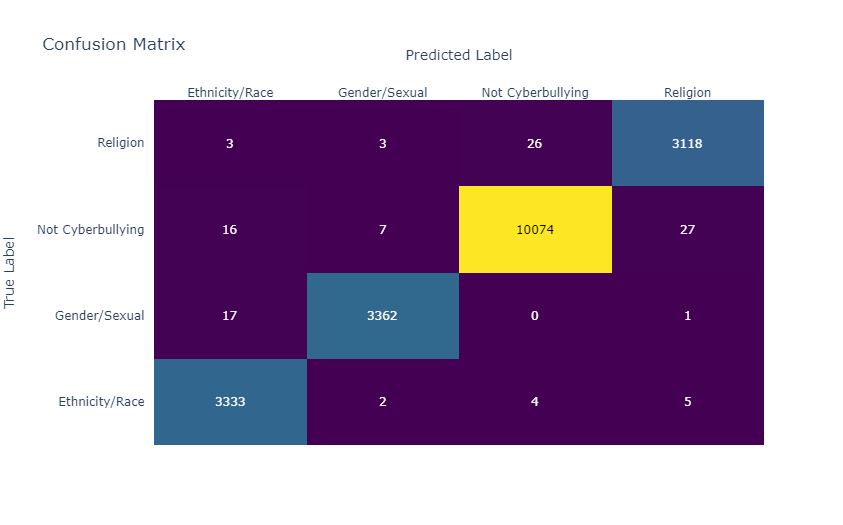

In [14]:
example_text = ['I can do this all day']
encodings = tokenizer(example_text, truncation=True, padding=True)
example_encodings = {"input_ids": encodings['input_ids'], "attention_mask": encodings['attention_mask']} # Replace 0 with an appropriate label or dummy label
example_dataset = CustomDataset(example_encodings)
predictions = trainer.predict(example_dataset)
predicted_label_idx = np.argmax(predictions.predictions, axis=-1)[0]
label_mapping = {'ethnicity/race': 0, 'not_cyberbullying': 2, 'religion': 3, 'gender/sexual': 1}
predicted_label = [key for key, value in label_mapping.items() if value == predicted_label_idx]

print(f"Predicted label: {predicted_label}")

Predicted label: ['not_cyberbullying']
